In [1]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch

from loss_traces.config import STORAGE_DIR

# from loss_traces.config import MODEL_DIR
from loss_traces.data_processing.data_processing import (
    get_no_shuffle_train_loader,
    get_num_classes,
    prepare_transform,
    get_trainset
)
from loss_traces.models.model import load_model
from loss_traces.results.final_model_metrics import get_final_model_metrics
from loss_traces.results.result_processing import (
    get_attackr_scores,
    get_lira_scores,
    get_rmia_scores,
    get_trace_reduction,
)
from loss_traces.results.utils import (
    make_precision_recall_at_k_df_single_threshold,
    make_precision_recall_at_k_df,
)
from loss_traces.attacks import AttackConfig, RMIAAttack
from sklearn.metrics import roc_curve

from privacy_onion.layer_utils import (get_lt_iqr)



In [2]:
import os
os.chdir("../")
plt.style.use("plot_style.mplstyle")

In [3]:
exp_id = 'wrn28-2_CIFAR_5_l0'
config = {
    "dataset": "CIFAR10",
    "arch": "wrn28-2",
    "batchsize": 16,
    "num_workers": 4,
    "augment": True,
    "device": "cuda",
}


def _initialize_model_and_data(config):
    attack_loaders = [
        get_no_shuffle_train_loader(
            config["dataset"],
            config["arch"],
            config["batchsize"],
            config["num_workers"],
        )
    ]

    if config["augment"]:
        attack_loaders.append(
            get_no_shuffle_train_loader(
                config["dataset"],
                config["arch"],
                config["batchsize"],
                config["num_workers"],
                mirror_all=True,
            )
        )

    model = load_model(config["arch"], get_num_classes(config["dataset"])).to(
        config["device"]
    )

    return model, attack_loaders

In [4]:
exp_id = 'wrn28-2_CIFAR_5_l0'
df = get_lt_iqr(exp_id)

MODEL_DIR = "trained_models"

saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/target", weights_only=False)

model, data_loader = _initialize_model_and_data(config)
model.load_state_dict(saves["model_state_dict"])

<All keys matched successfully>

In [5]:
df_metrics = get_final_model_metrics(model, data_loader[0], metrics = ['loss'])

100%|██████████| 3125/3125 [00:15<00:00, 202.25it/s]


In [12]:
df_metrics['og_idx'] = range(len(df_metrics))
df_merged = pd.merge(df, df_metrics, on= 'og_idx', how='inner')

In [13]:
members = df_merged[df_merged['target_trained_on'] == True]
top_score = members.sort_values(by='lt_iqr', ascending=False)
top_score

,lt_iqr,og_idx,target_trained_on,loss,confidence_margin,confidence,confidence_log_odds
9235,7.128746e+00,9235,True,1.314848e-03,13.454239,0.998686,6.633377
29803,6.720275e+00,29803,True,1.351278e-03,14.062497,0.998650,6.606045
10487,5.893435e+00,10487,True,3.183573e-04,16.783852,0.999682,8.052233
24461,5.891798e+00,24461,True,2.776718e-02,7.245866,0.972615,3.569984
9850,5.652552e+00,9850,True,1.008754e-01,4.607169,0.904046,2.243007
...,...,...,...,...,...,...,...
6342,1.072883e-06,6342,True,9.417489e-06,24.452274,0.999991,11.572927
10055,9.536739e-07,10055,True,1.192093e-07,33.335007,1.000000,15.942385
39549,9.536738e-07,39549,True,3.814690e-06,26.280704,0.999996,12.476645
7900,5.960463e-07,7900,True,8.106199e-06,24.520775,0.999992,11.722869


## WRN28-2 CIFAR10

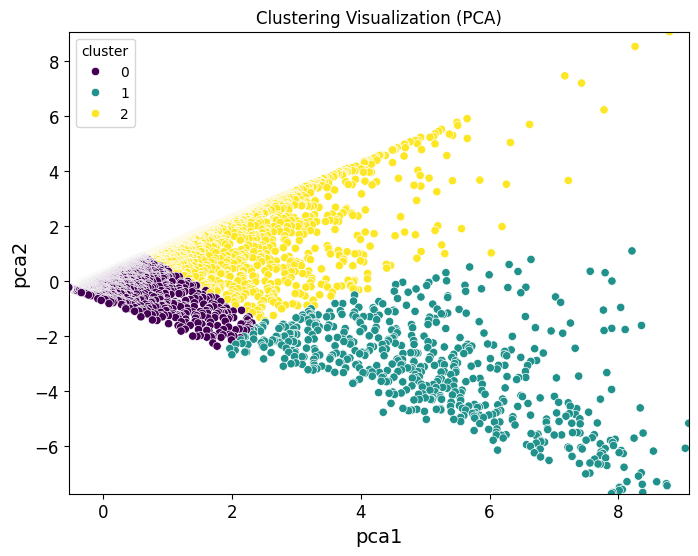

In [14]:
# df_filtered
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

df_filtered_inf = top_score.replace([np.inf, -np.inf], np.nan).dropna()
X = df_filtered_inf[['lt_iqr', 'confidence']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.cluster import KMeans

k=3
kmeans = KMeans(n_clusters=k, random_state=0)
df_filtered_inf['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce to 2D 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_filtered_inf['pca1'], df_filtered_inf['pca2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_filtered_inf, x='pca1', y='pca2', hue='cluster', palette='viridis')
plt.title('Clustering Visualization (PCA)')
plt.show()

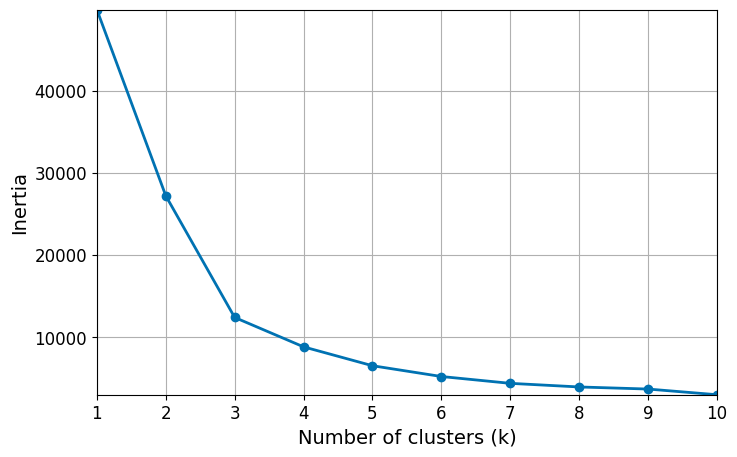

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [15]:
df_filtered_inf.groupby('cluster')[['lt_iqr', 'loss', 'confidence_margin']].mean()

,lt_iqr,loss,confidence_margin
cluster,,,
0,0.121103,0.003951,18.352972
1,1.030691,0.844148,1.475730
2,1.591506,0.103966,11.756449


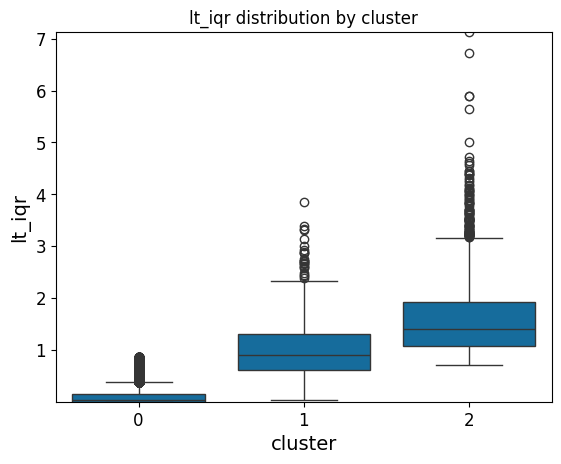

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_filtered_inf, x='cluster', y='lt_iqr')
plt.title("lt_iqr distribution by cluster")
plt.show()

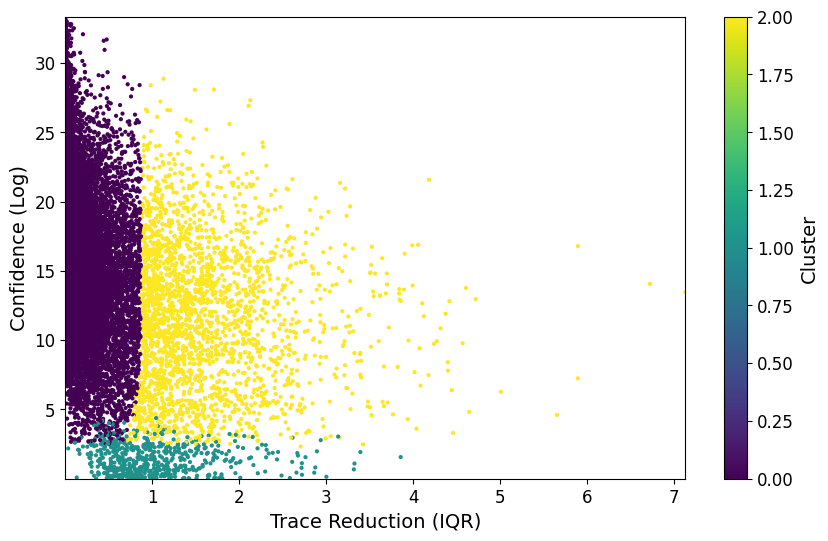

In [21]:
plt.figure(figsize=(10, 6))
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
plt.scatter(df_filtered_inf['lt_iqr'], df_filtered_inf['confidence_margin'], c=df_filtered_inf['cluster'], cmap='viridis', s=4)  # s=4 for marker size
plt.xlabel('Trace Reduction (IQR)')
plt.ylabel('Confidence (Log)')
plt.colorbar(label='Cluster')
plt.show()

In [23]:
df_filtered_inf['cluster'].value_counts()

cluster
0    21941
2     2448
1      570
Name: count, dtype: int64

In [17]:
safe = df_filtered_inf[df_filtered_inf['cluster'].isin([0])]['og_idx']
safe.to_pickle("trained_models/layer_target_indices/cluster_test/layer_0_safe.pkl")

vulnerable = df_filtered_inf[df_filtered_inf['cluster'].isin([1, 2])]['og_idx']
full_safe = [i for i in range(len(df)) if i not in vulnerable.values]
full_safe = pd.DataFrame(full_safe, columns=['og_idx'])
full_safe.to_pickle("trained_models/layer_target_indices/cluster_test/layer_0_full_safe.pkl")

In [18]:
import pickle
safe = pickle.load(open("/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/cluster_test/layer_0_full_safe.pkl", "rb"))

In [37]:
safev2 = pickle.load(open("/vol/bitbucket/vb524/lossv2/trained_models/layer_target_indices/wrn28-CIFAR_2/layer_0_full_safe.pkl", "rb"))

In [19]:
safe

,og_idx
0,0
1,1
2,2
3,3
4,4
...,...
46977,49995
46978,49996
46979,49997
46980,49998
